In [1]:
# Install spaCy + small English model, and NLTK
!pip -q install -U spacy==3.8.2 nltk==3.9.1
!python -m spacy download en_core_web_sm
print("✅ Installed spaCy 3.8.x + en_core_web_sm, NLTK 3.9.1")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ Installed spaCy 3.8.x + en_core_web_sm, NLTK 3.9.1


In [2]:
import nltk, spacy, sys, time

# Make sure VADER lexicon is available
try:
    nltk.data.find("sentiment/vader_lexicon")
    print("✅ VADER already present")
except LookupError:
    try:
        nltk.download("vader_lexicon")
        print("✅ VADER downloaded")
    except Exception as e:
        raise RuntimeError("Could not download VADER.") from e


# Load spaCy model
nlp = spacy.load("en_core_web_sm")
print("✅ spaCy model loaded:", nlp.meta.get("name"), nlp.meta.get("version"))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


✅ VADER downloaded
✅ spaCy model loaded: core_web_sm 3.8.0


In [3]:
import re, pandas as pd, nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1) Ensure NLTK resources: stopwords, punkt, and punkt_tab
for pkg, kind in [("stopwords","corpora"), ("punkt","tokenizers"), ("punkt_tab","tokenizers")]:
    try:
        nltk.data.find(f"{kind}/{pkg}")
        print(f"✓ {pkg} ready")
    except LookupError:
        nltk.download(pkg)
        print(f"✓ {pkg} downloaded")

# 2) Load your uploaded BBCNews.csv
raw = pd.read_csv("BBCNews.csv")                # <- usa el archivo que acabas de subir
raw = raw.rename(columns={"descr":"content","tags":"tags"})
raw["content"] = raw["content"].astype(str)
raw["tags"] = raw["tags"].astype(str).str.lower()

# 3) Map tags -> 5 BBC categories
def to_bbc_cat(s: str):
    if re.search(r"\bsport", s): return "sport"
    if re.search(r"\bbusiness", s): return "business"
    if re.search(r"\bentertain", s): return "entertainment"
    if re.search(r"\bpolitic", s): return "politics"
    if re.search(r"\btech", s): return "tech"
    return None
raw["category"] = raw["tags"].apply(to_bbc_cat)
raw = raw.dropna(subset=["category","content"]).copy()

# 4) Quick clean + tokenize (same criterio que antes)
EN_STOP = set(stopwords.words("english"))
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\S+|https\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def preprocess_text(s: str) -> str:
    toks = word_tokenize(clean_text(s))
    toks = [t for t in toks if t not in EN_STOP and len(t) > 2]
    return " ".join(toks)

raw["clean_content"] = raw["content"].apply(preprocess_text)
df = raw[["content","clean_content","category"]].copy()

print("✅ df ready:", df.shape)
df.head(3)


✓ stopwords ready
✓ punkt ready
✓ punkt_tab ready
✅ df ready: (2260, 3)


,content,clean_content,category
0,chelsea sack mutu chelsea have sacked adrian ...,chelsea sack mutu chelsea sacked adrian mutu f...,sport
1,record fails to lift lacklustre meet yelena i...,record fails lift lacklustre meet yelena isinb...,sport
2,edu describes tunnel fracas arsenals edu has ...,edu describes tunnel fracas arsenals edu lifte...,sport


In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

sia = SentimentIntensityAnalyzer()

def vader_compound(text: str) -> float:
    try:
        return float(sia.polarity_scores(str(text))["compound"])
    except Exception:
        return 0.0

# Use clean_content if present, otherwise fall back to content
text_col = "clean_content" if "clean_content" in df.columns else "content"
df["sentiment"] = df[text_col].astype(str).apply(vader_compound)

def to_bucket(x):
    if x >  0.05: return "positive"
    if x < -0.05: return "negative"
    return "neutral"

df["sentiment_label"] = df["sentiment"].apply(to_bucket)
print(df["sentiment_label"].value_counts())
df.head(3)


sentiment_label
positive    1643
negative     605
neutral       12
Name: count, dtype: int64


,content,clean_content,category,sentiment,sentiment_label
0,chelsea sack mutu chelsea have sacked adrian ...,chelsea sack mutu chelsea sacked adrian mutu f...,sport,0.1637,positive
1,record fails to lift lacklustre meet yelena i...,record fails lift lacklustre meet yelena isinb...,sport,0.9930,positive
2,edu describes tunnel fracas arsenals edu has ...,edu describes tunnel fracas arsenals edu lifte...,sport,0.8729,positive


In [5]:
# POS analysis with spaCy (we already loaded nlp = en_core_web_sm)
import numpy as np
import pandas as pd

texts = df["clean_content"].tolist()
docs = list(nlp.pipe(texts, batch_size=64))

# count POS per doc
pos_rows = []
for doc, cat in zip(docs, df["category"].values):
    counts = {}
    for tok in doc:
        if tok.is_space:
            continue
        counts[tok.pos_] = counts.get(tok.pos_, 0) + 1
    counts["category"] = cat
    pos_rows.append(counts)

pos_df = pd.DataFrame(pos_rows).fillna(0)
# Exclude the 'category' column from integer conversion
pos_cols = [col for col in pos_df.columns if col != 'category']
pos_df[pos_cols] = pos_df[pos_cols].astype(int)

pos_rate = pos_df.groupby("category").sum()
pos_rate = pos_rate.div(pos_rate.sum(axis=1), axis=0)  # normalize row-wise
print(pos_rate.head())

                  PROPN      VERB      NOUN       ADJ       ADV       AUX  \
category                                                                    
business       0.121331  0.217144  0.440140  0.133665  0.040509  0.015326   
entertainment  0.165401  0.205669  0.407938  0.122181  0.042334  0.014264   
politics       0.133223  0.232132  0.410787  0.125991  0.041432  0.023690   
sport          0.207244  0.210309  0.351585  0.117188  0.046262  0.019940   
tech           0.085367  0.231455  0.452004  0.131310  0.046531  0.016115   

                    NUM       ADP      INTJ     SCONJ       DET      PART  \
category                                                                    
business       0.012489  0.008811  0.000417  0.005166  0.001308  0.000899   
entertainment  0.016330  0.009936  0.001017  0.003410  0.002022  0.002973   
politics       0.009192  0.008848  0.000745  0.003931  0.001822  0.002831   
sport          0.016358  0.008969  0.000996  0.004978  0.002450  0.005017  

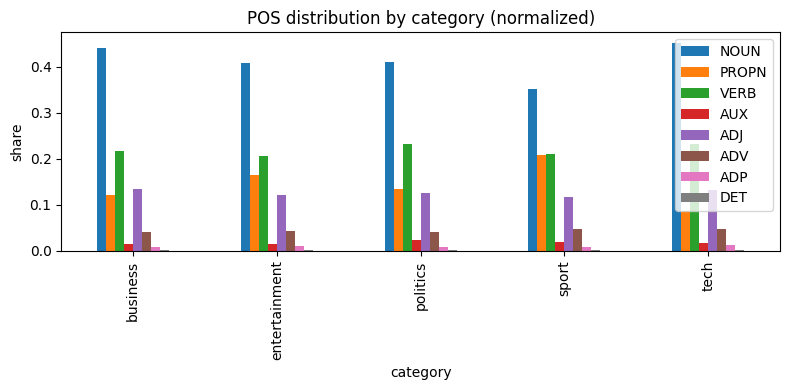

In [6]:
import matplotlib.pyplot as plt

keep_pos = ["NOUN","PROPN","VERB","AUX","ADJ","ADV","ADP","DET"]
plot_df = pos_rate[keep_pos].copy()
plot_df.plot(kind="bar", figsize=(8,4))
plt.title("POS distribution by category (normalized)")
plt.ylabel("share"); plt.xlabel("category"); plt.tight_layout(); plt.show()


In [7]:
from collections import Counter, defaultdict

dep_counts = defaultdict(Counter)
for doc, cat in zip(docs, df["category"].values):
    for tok in doc:
        if tok.head is tok:  # skip root->root
            continue
        pair = f"{tok.head.pos_}->{tok.pos_}"
        dep_counts[cat][pair] += 1

for cat, ctr in dep_counts.items():
    print(f"\nTop dependency POS pairs – {cat}")
    for k, v in ctr.most_common(10):
        print(f"{k:18s} {v}")



Top dependency POS pairs – sport
VERB->NOUN         16575
VERB->VERB         15472
NOUN->NOUN         14935
PROPN->PROPN       10883
NOUN->ADJ          9747
VERB->PROPN        5252
NOUN->VERB         4953
NOUN->PROPN        4829
VERB->ADV          3204
PROPN->NOUN        3188

Top dependency POS pairs – politics
VERB->NOUN         16590
NOUN->NOUN         15891
VERB->VERB         14658
NOUN->ADJ          9461
PROPN->PROPN       5076
NOUN->VERB         4968
VERB->PROPN        3426
NOUN->PROPN        2952
VERB->ADV          2442
PROPN->NOUN        2203

Top dependency POS pairs – business
NOUN->NOUN         25552
VERB->NOUN         23934
VERB->VERB         18957
NOUN->ADJ          14517
NOUN->VERB         6844
PROPN->PROPN       5707
NOUN->PROPN        4692
VERB->PROPN        4217
VERB->ADV          3328
PROPN->NOUN        2481

Top dependency POS pairs – entertainment
NOUN->NOUN         17393
VERB->NOUN         15861
VERB->VERB         12957
NOUN->ADJ          9559
PROPN->PROPN       6

In [8]:
# Use a pipeline with NER enabled
import spacy
nlp_ner = spacy.load("en_core_web_sm", disable=["lemmatizer","textcat"])
ents_keep = {"PERSON","ORG","GPE","DATE","MONEY"}

docs_ner = list(nlp_ner.pipe(df["clean_content"].tolist(), batch_size=32))

rows = []
for doc, cat in zip(docs_ner, df["category"].values):
    for ent in doc.ents:
        if ent.label_ in ents_keep:
            rows.append({"entity": ent.text, "label": ent.label_, "category": cat})

ents_df = pd.DataFrame(rows)
print(ents_df.shape)
ents_df.head(10)


(27130, 3)


,entity,label,category
0,october,DATE,sport
1,last season,DATE,sport
2,fifa,ORG,sport
3,michelle verroken verroken,PERSON,sport
4,october,DATE,sport
5,centimetre time athletics,ORG,sport
6,samaria,GPE,sport
7,jason gardener,PERSON,sport
8,madrid,GPE,sport
9,mark lewisfrancis,PERSON,sport


In [9]:
print("Top 15 entities by label:")
for lab in sorted(ents_keep):
    sub = ents_df[ents_df["label"] == lab]
    print(f"\n== {lab} ==")
    print(sub["entity"].str.lower().value_counts().head(15))


Top 15 entities by label:

== DATE ==
entity
last year    335
years        263
january      234
december     207
wednesday    180
tuesday      177
today        177
sunday       173
monday       169
february     161
last week    160
year         159
friday       151
november     146
thursday     137
Name: count, dtype: int64

== GPE ==
entity
london         321
britain        320
france         267
china          177
japan          168
new york       135
iraq           133
italy          116
liverpool      113
england         99
india           95
new zealand     85
russia          85
australia       79
newcastle       78
Name: count, dtype: int64

== MONEY ==
entity
million dollar                        27
aviator million dollar                 8
billions dollars                       6
million euros million                  6
millions dollars                       6
multibillion dollar                    4
hundreds millions dollars              4
eighty per cent                       

In [10]:
pivot = (ents_df.assign(entity_norm=ents_df["entity"].str.lower())
         .groupby(["entity_norm","label","category"]).size()
         .reset_index(name="count"))

print("\nSample entity-category rows:")
pivot.sort_values(["entity_norm","count"], ascending=[True, False]).head(20)



Sample entity-category rows:


,entity_norm,label,category,count
0,aaas american association advancement science,ORG,tech,1
1,aaas sheffield ballymena sprinter paul brizzel,ORG,sport,1
2,aadc,PERSON,entertainment,1
3,aamir khans,PERSON,entertainment,1
4,aara association represents bank,ORG,business,1
5,aaron,PERSON,sport,2
6,aaron persico,PERSON,sport,1
7,abba,PERSON,entertainment,1
8,abbas,PERSON,politics,4
9,abbasi croydon,ORG,politics,1


In [11]:
import os

os.makedirs("outputs/analysis", exist_ok=True)

# Sentiment
df[["category","sentiment","sentiment_label"]].to_csv("outputs/analysis/sentiment_by_doc.csv", index=False)
df.groupby(["category","sentiment_label"]).size().unstack(fill_value=0)\
  .to_csv("outputs/analysis/sentiment_distribution.csv")

# POS
pos_rate.to_csv("outputs/analysis/pos_rates_by_category.csv")

# Dependency pairs (flatten)
dep_rows = []
for cat, ctr in dep_counts.items():
    for pair, cnt in ctr.items():
        dep_rows.append({"category":cat, "pair":pair, "count":cnt})
pd.DataFrame(dep_rows).to_csv("outputs/analysis/dep_pairs_by_category.csv", index=False)

# Entities
if not ents_df.empty:
    ents_df.to_csv("outputs/analysis/entities_raw.csv", index=False)
    pivot.to_csv("outputs/analysis/entities_by_category.csv", index=False)

print("✅ Saved analysis files:")
!ls -la outputs/analysis | sed -n '1,60p'


✅ Saved analysis files:
total 1096
drwxr-xr-x 2 root root   4096 Nov  1 22:02 .
drwxr-xr-x 3 root root   4096 Nov  1 22:02 ..
-rw-r--r-- 1 root root  13093 Nov  1 22:02 dep_pairs_by_category.csv
-rw-r--r-- 1 root root 324921 Nov  1 22:02 entities_by_category.csv
-rw-r--r-- 1 root root 701147 Nov  1 22:02 entities_raw.csv
-rw-r--r-- 1 root root   1742 Nov  1 22:02 pos_rates_by_category.csv
-rw-r--r-- 1 root root  56178 Nov  1 22:02 sentiment_by_doc.csv
-rw-r--r-- 1 root root    126 Nov  1 22:02 sentiment_distribution.csv


In [12]:
def newsbot_analyze(text: str):
    from nltk.sentiment import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    # preprocess using earlier function (clean_text + stopwords via VADER step ya cargado)
    cleaned = text.lower()
    sent_score = sia.polarity_scores(cleaned)["compound"]
    sent_label = "positive" if sent_score > 0.05 else ("negative" if sent_score < -0.05 else "neutral")

    doc = nlp_ner(text)
    ents = [(e.text, e.label_) for e in doc.ents if e.label_ in {"PERSON","ORG","GPE","DATE","MONEY"}]
    return {"sentiment": sent_label, "sentiment_score": sent_score, "entities": ents}

sample_text = "Microsoft announced a $2 billion investment in London on Monday to expand its AI datacenters."
newsbot_analyze(sample_text)


{'sentiment': 'positive',
 'sentiment_score': 0.3182,
 'entities': [('Microsoft', 'ORG'),
  ('$2 billion', 'MONEY'),
  ('London', 'GPE'),
  ('Monday', 'DATE'),
  ('AI', 'GPE')]}

In [13]:

import os

os.makedirs("outputs/analysis", exist_ok=True)

# Sentiment
df[["category","sentiment","sentiment_label"]].to_csv("outputs/analysis/sentiment_by_doc.csv", index=False)
df.groupby(["category","sentiment_label"]).size().unstack(fill_value=0)\
  .to_csv("outputs/analysis/sentiment_distribution.csv")

# POS
pos_rate.to_csv("outputs/analysis/pos_rates_by_category.csv")

# Dependency pairs (flatten)
dep_rows = []
for cat, ctr in dep_counts.items():
    for pair, cnt in ctr.items():
        dep_rows.append({"category":cat, "pair":pair, "count":cnt})
pd.DataFrame(dep_rows).to_csv("outputs/analysis/dep_pairs_by_category.csv", index=False)

# Entities
if not ents_df.empty:
    ents_df.to_csv("outputs/analysis/entities_raw.csv", index=False)
    pivot.to_csv("outputs/analysis/entities_by_category.csv", index=False)

print("✅ Saved analysis files:")
!ls -la outputs/analysis | sed -n '1,60p'


✅ Saved analysis files:
total 1096
drwxr-xr-x 2 root root   4096 Nov  1 22:02 .
drwxr-xr-x 3 root root   4096 Nov  1 22:02 ..
-rw-r--r-- 1 root root  13093 Nov  1 22:02 dep_pairs_by_category.csv
-rw-r--r-- 1 root root 324921 Nov  1 22:02 entities_by_category.csv
-rw-r--r-- 1 root root 701147 Nov  1 22:02 entities_raw.csv
-rw-r--r-- 1 root root   1742 Nov  1 22:02 pos_rates_by_category.csv
-rw-r--r-- 1 root root  56178 Nov  1 22:02 sentiment_by_doc.csv
-rw-r--r-- 1 root root    126 Nov  1 22:02 sentiment_distribution.csv


In [14]:
import shutil

shutil.make_archive("analysis_results", "zip", "outputs/analysis")
print("✅ Created ZIP file: analysis_results.zip")
!ls -lh analysis_results.zip


✅ Created ZIP file: analysis_results.zip
-rw-r--r-- 1 root root 217K Nov  1 22:06 analysis_results.zip
